<h3> Generowanie nowego tekstu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
f = open('cytaty.txt','r')  #otwiram plik z cytatami
cytaty = f.read().split('\n')
f.close()

In [3]:
cytaty[:4] #pierwsze cztery cytaty

['The best and most beautiful things in the world cannot be seen or even touched - they must be felt with the heart.',
 'The best preparation for tomorrow is doing your best today.',
 'Put your heart, mind, and soul into even your smallest acts. This is the secret of success.',
 "I can't change the direction of the wind, but I can adjust my sails to always reach my destination."]

In [4]:
len(cytaty) #ile wszysktich cytatow?

403

In [5]:
cytat9 = cytaty[9] #wybieram przykladowy cytat
print(cytat9)

From a small seed a mighty trunk may grow.


In [6]:
len(cytat9) #ile ma znakow?                

42

In [7]:
vocab = list(set(cytat9)) + ["<BOS>", "<EOS>"] #tworze liste znakow ktore wystepują w wybranym cytacie, dodaje dwa nowe BOS = początek sekwencji, EOS = koniec sekwencji

In [8]:
print(vocab)

['d', 'F', 'y', 'o', '.', 'u', 'w', 't', 'k', ' ', 'e', 'r', 'l', 'i', 'g', 's', 'm', 'a', 'h', 'n', '<BOS>', '<EOS>']


In [9]:
len(vocab) #ile jest znakow unikalnych?

22

In [10]:
vocab_size = len(vocab) #zapisuje te informacje pod zmienną

In [11]:
#tworze dwa pomocnicze słowniki
vocab1 = {s: i for i, s in enumerate(vocab)}
vocab2 = {i: s for i, s in enumerate(vocab)}

In [12]:
print(vocab1)

{'d': 0, 'F': 1, 'y': 2, 'o': 3, '.': 4, 'u': 5, 'w': 6, 't': 7, 'k': 8, ' ': 9, 'e': 10, 'r': 11, 'l': 12, 'i': 13, 'g': 14, 's': 15, 'm': 16, 'a': 17, 'h': 18, 'n': 19, '<BOS>': 20, '<EOS>': 21}


In [13]:
print(vocab2)

{0: 'd', 1: 'F', 2: 'y', 3: 'o', 4: '.', 5: 'u', 6: 'w', 7: 't', 8: 'k', 9: ' ', 10: 'e', 11: 'r', 12: 'l', 13: 'i', 14: 'g', 15: 's', 16: 'm', 17: 'a', 18: 'h', 19: 'n', 20: '<BOS>', 21: '<EOS>'}


In [14]:
#Uwaga: tak sie definiuje macierz jednostkową, my będziemy interpretowac wiersze jako reprezentacje one-hot vectors dla znakow
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [15]:
# Model: 

class TextGenerator(nn.Module):
    def __init__(self, v_size, hidden_size, n_layers=1):
        super().__init__()
        self.ident = torch.eye(v_size) #macierz wektorow one-hot encoding dla wszytkich znakow
        self.gru = nn.GRU(v_size, hidden_size, n_layers, batch_first=True) #uzyjemy sobie GRU
        self.decoder = nn.Linear(hidden_size, v_size) #jako dekoder wezmiemy przeksztalcenie liniowe
    
    def forward(self, inp, hidden=None):
        inp = self.ident[inp]                  #one-hot vector dla kolejnego znaku
        output, hidden = self.gru(inp, hidden) #zastosowanie GRU
        output = self.decoder(output)          #rozklad kolejnych znakow
        return output, hidden

In [16]:
model = TextGenerator(vocab_size, 16) #buduje model, z wymiarem dla stanu ukrytego = 16

In [17]:
criterion = nn.CrossEntropyLoss() #funkcja kosztu

In [18]:
bos = torch.Tensor([vocab1["<BOS>"]]).long().unsqueeze(0) #zaczynamy od BOS - patrzymy jaki ma indeks
print(bos)

tensor([[20]])


In [19]:
output, hidden = model(bos, hidden=None)
print(output) #rozklad po pierwszym tokenie - tensor 3D

tensor([[[-0.0623, -0.2222, -0.0150,  0.1365,  0.0983,  0.1993,  0.1391,
          -0.1728, -0.0231, -0.2330, -0.2657,  0.1632, -0.0490, -0.2230,
           0.1564,  0.1299,  0.1966, -0.0765,  0.2454, -0.0259, -0.1660,
          -0.0031]]], grad_fn=<AddBackward0>)


In [20]:
print(output.reshape(-1, vocab_size)) #tensor 2D

tensor([[-0.0623, -0.2222, -0.0150,  0.1365,  0.0983,  0.1993,  0.1391, -0.1728,
         -0.0231, -0.2330, -0.2657,  0.1632, -0.0490, -0.2230,  0.1564,  0.1299,
          0.1966, -0.0765,  0.2454, -0.0259, -0.1660, -0.0031]],
       grad_fn=<ReshapeAliasBackward0>)


In [21]:
target = torch.Tensor([vocab1[cytat9[0]]]).long().unsqueeze(0) #pierwszy znak z cytatu 
print(target)

tensor([[1]])


In [22]:
print(criterion(output.reshape(-1, vocab_size), target.reshape(-1))) #wartosc funkcji kosztu

tensor(3.3223, grad_fn=<NllLossBackward0>)


In [23]:
target.reshape(-1)

tensor([1])

<h4> Zadanie1: Wyjaśnij skąd wzięła się wartość funkcji kosztu (wyznacz ją poprzez bezpośrednie obliczenia).

In [24]:
output, hidden = model(target, hidden) #uzyj hidden do wygenerowania nowego output i hidden
print(output) 

tensor([[[-0.0276, -0.2690,  0.0260,  0.1704,  0.1412,  0.2731,  0.1469,
          -0.2622, -0.0477, -0.1721, -0.2899,  0.1170,  0.0115, -0.2258,
           0.1195,  0.1773,  0.2310, -0.0768,  0.2129, -0.0802, -0.1289,
           0.0324]]], grad_fn=<AddBackward0>)


In [25]:
target = torch.Tensor([vocab1[cytat9[1]]]).long().unsqueeze(0) #drugi znak w cytacie
print(criterion(output.reshape(-1, vocab_size), target.reshape(-1)))        

tensor(2.9920, grad_fn=<NllLossBackward0>)


In [26]:
#analogicznie dla pozotalych znakow
for i in range(2, len(cytat9)):
    output, hidden = model(target, hidden) #generuje hidden i output w oparciu o poprzedni znak i hidden
    target = torch.Tensor([vocab1[cytat9[i]]]).long().unsqueeze(0) #jaki mial byc kolejny znak?
    loss = criterion(output.reshape(-1, vocab_size),target.reshape(-1)) #na ile sie pokrywa przewidywany znak z tym co generuje model      
    print(i, loss)

2 tensor(3.0214, grad_fn=<NllLossBackward0>)
3 tensor(2.9355, grad_fn=<NllLossBackward0>)
4 tensor(3.4547, grad_fn=<NllLossBackward0>)
5 tensor(3.2883, grad_fn=<NllLossBackward0>)
6 tensor(3.2219, grad_fn=<NllLossBackward0>)
7 tensor(2.8485, grad_fn=<NllLossBackward0>)
8 tensor(2.9043, grad_fn=<NllLossBackward0>)
9 tensor(3.1984, grad_fn=<NllLossBackward0>)
10 tensor(3.0012, grad_fn=<NllLossBackward0>)
11 tensor(3.0398, grad_fn=<NllLossBackward0>)
12 tensor(3.4019, grad_fn=<NllLossBackward0>)
13 tensor(2.8991, grad_fn=<NllLossBackward0>)
14 tensor(3.3230, grad_fn=<NllLossBackward0>)
15 tensor(3.3401, grad_fn=<NllLossBackward0>)
16 tensor(3.1339, grad_fn=<NllLossBackward0>)
17 tensor(3.4604, grad_fn=<NllLossBackward0>)
18 tensor(3.2840, grad_fn=<NllLossBackward0>)
19 tensor(3.2394, grad_fn=<NllLossBackward0>)
20 tensor(2.8135, grad_fn=<NllLossBackward0>)
21 tensor(3.4494, grad_fn=<NllLossBackward0>)
22 tensor(2.9808, grad_fn=<NllLossBackward0>)
23 tensor(2.7827, grad_fn=<NllLossBackward

In [27]:
#na koncu dla znaku konca sekwencji
output, hidden = model(target, hidden)
target = torch.Tensor([vocab1["<EOS>"]]).long().unsqueeze(0)
loss = criterion(output.reshape(-1, vocab_size),target.reshape(-1))             
print(loss)

tensor(3.0567, grad_fn=<NllLossBackward0>)


<h4>Krótsze rozwiązanie


In [28]:
cytat_ch = ["<BOS>"] + list(cytat9) + ["<EOS>"]
print(cytat_ch)

['<BOS>', 'F', 'r', 'o', 'm', ' ', 'a', ' ', 's', 'm', 'a', 'l', 'l', ' ', 's', 'e', 'e', 'd', ' ', 'a', ' ', 'm', 'i', 'g', 'h', 't', 'y', ' ', 't', 'r', 'u', 'n', 'k', ' ', 'm', 'a', 'y', ' ', 'g', 'r', 'o', 'w', '.', '<EOS>']


In [29]:
cytat_indices = [vocab1[ch] for ch in cytat_ch] #indeksy
print(cytat_indices)

[20, 1, 11, 3, 16, 9, 17, 9, 15, 16, 17, 12, 12, 9, 15, 10, 10, 0, 9, 17, 9, 16, 13, 14, 18, 7, 2, 9, 7, 11, 5, 19, 8, 9, 16, 17, 2, 9, 14, 11, 3, 6, 4, 21]


In [30]:
cytat_tensor = torch.Tensor(cytat_indices).long().unsqueeze(0) #przerabiamy na tensor
print(cytat_tensor) 

tensor([[20,  1, 11,  3, 16,  9, 17,  9, 15, 16, 17, 12, 12,  9, 15, 10, 10,  0,
          9, 17,  9, 16, 13, 14, 18,  7,  2,  9,  7, 11,  5, 19,  8,  9, 16, 17,
          2,  9, 14, 11,  3,  6,  4, 21]])


In [31]:
print(cytat_tensor.shape)

torch.Size([1, 44])


In [32]:
print(cytat_tensor[:,:-1])  #bez EOS

tensor([[20,  1, 11,  3, 16,  9, 17,  9, 15, 16, 17, 12, 12,  9, 15, 10, 10,  0,
          9, 17,  9, 16, 13, 14, 18,  7,  2,  9,  7, 11,  5, 19,  8,  9, 16, 17,
          2,  9, 14, 11,  3,  6,  4]])


In [33]:
print(cytat_tensor[:,1:])  #bez BOS

tensor([[ 1, 11,  3, 16,  9, 17,  9, 15, 16, 17, 12, 12,  9, 15, 10, 10,  0,  9,
         17,  9, 16, 13, 14, 18,  7,  2,  9,  7, 11,  5, 19,  8,  9, 16, 17,  2,
          9, 14, 11,  3,  6,  4, 21]])


In [34]:
#mozna przejsc wszystkie znaki bez pętli for

output, hidden = model(cytat_tensor[:,:-1])
target = cytat_tensor[:,1:]                 
loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
print(loss) #taka zbiorcza wartosc funkcji kosztu

tensor(3.1317, grad_fn=<NllLossBackward0>)


In [35]:
#Trening 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #optymalizator
criterion = nn.CrossEntropyLoss()                          #funkcja kosztu
for it in range(3000):
    optimizer.zero_grad()
    output, hidden = model(cytat_tensor[:,:-1])
    loss = criterion(output.reshape(-1, vocab_size),target.reshape(-1))
    loss.backward()
    optimizer.step()
    if (it+1) % 300 == 0:  #jak sobie radzi nasz model co 100 epoke?
        print(f"[Iter {it+1}] Loss value: {float(loss)}")

[Iter 300] Loss value: 1.0709996223449707
[Iter 600] Loss value: 0.15126468241214752
[Iter 900] Loss value: 0.04709853604435921
[Iter 1200] Loss value: 0.02358001098036766
[Iter 1500] Loss value: 0.014323363080620766
[Iter 1800] Loss value: 0.009610854089260101
[Iter 2100] Loss value: 0.006851714104413986
[Iter 2400] Loss value: 0.0050923689268529415
[Iter 2700] Loss value: 0.0039008131716400385
[Iter 3000] Loss value: 0.0030554949771612883


<h4> Generowanie nowego tekstu na podstawie modelu.

In [36]:
#funkcja do generowania nowej sekwencji
#będziemy lekko modyfikowac prawdopodobienstwa wylosowania danego znaku poprzez czynnik temperaturowy, gdy T=1, to nie zmieniamy, gdy T<1 to zwiększamy prp wystapienia najbardziej prawdopodobnych znakow, gdy T>1 to zmniejszamy prp najbardziej prawdopodobnych znakow


def sample_sequence(model, max_len=100, temperature=0.8):
    generated_sequence = "" #tu będzie przechowywana wygenerowana sekwencja
    inp = torch.Tensor([vocab1["<BOS>"]]).long() #zaczynamy od BOS
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden) #co nam przeiwduje model?
        output_dist = output.data.view(-1).div(temperature).exp() #uwzględniamy czynnik temperaturowy
        top_i = int(torch.multinomial(output_dist, 1)[0]) #indeks przewidywanego znaku
        predicted_char = vocab2[top_i] #przewidywany znak
        if predicted_char == "<EOS>": #jakim przewidywanym znakiem jest EOS to konczymy
            break
        generated_sequence += predicted_char #dodajemy kolejny znak
        inp = torch.Tensor([top_i]).long() #zapisujemy indeks w postaci tensora
    return generated_sequence

In [37]:
print(sample_sequence(model, temperature=0.4)) #T=0.4

From a small seed a mighty trunk may grow.


In [38]:
print(sample_sequence(model, temperature=1.0)) #T=1

From a small seed a mighty trunk may grow.


In [39]:
print(sample_sequence(model, temperature=1.5)) #T=1.5

From a small seed a mighty ttunk may groy.


In [40]:
print(sample_sequence(model, temperature=2.0)) #T=2

From a small seed ay aytw.rFrlr<BOS>may g


In [41]:
print(sample_sequence(model, temperature=5.0))  #T=5

wFeoo.sFiyk.mhtyoswnFFkmsrt iuumunk hlgiunk


<h4> Analiza wszytkich cytatów


In [42]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

text_field = Field(sequential=True, tokenize=lambda x: x, include_lengths=True, batch_first=True, use_vocab=True, init_token="<BOS>", eos_token="<EOS>")    
fields = [('text', text_field)]
cytaty = TabularDataset("cytaty.txt", "csv", fields) #laduje sobie dane jeszcze raz

In [43]:
len(cytaty) 

403

In [44]:
text_field.build_vocab(cytaty)

vocab1 = text_field.vocab.stoi #nie musimy tego robic ręcznie
vocab2 = text_field.vocab.itos #nie musimy tego robic ręcznie
vocab_size = len(text_field.vocab.itos)
vocab_size

72

In [45]:
#Batchowanie w sieciach rekurencyjnych - wstawka
data_iter = BucketIterator(cytaty, batch_size=16, sort_key=lambda x: len(x.text), sort_within_batch=True)

for (cytat, lengths), label in data_iter:
    print(lengths) #dlugosc cytatow w jednym batchu

tensor([41, 41, 41, 41, 40, 40, 40, 40, 40, 38, 38, 38, 38, 38, 37, 37])
tensor([37, 37, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35])
tensor([86, 85, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 81, 81, 81, 80])
tensor([35, 34, 34, 34, 33, 33, 33, 33, 32, 32, 31, 31, 30, 30, 30, 30])
tensor([63, 63, 63, 62, 62, 61, 61, 61, 61, 60, 60, 60, 60, 59, 59, 59])
tensor([68, 68, 68, 67, 66, 66, 65, 65, 65, 65, 64, 64, 64, 64, 63, 63])
tensor([79, 79, 78, 78, 77, 77, 77, 77, 77, 76, 76, 76, 76, 75, 75, 75])
tensor([58, 58, 58, 58, 58, 57, 57, 57, 57, 56, 56, 56, 56, 55, 55, 55])
tensor([46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44])
tensor([49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 46, 46])
tensor([74, 74, 73, 72, 71, 71, 71, 71, 71, 70, 69, 69, 69, 68, 68, 68])
tensor([51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49])
tensor([44, 44, 44, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42])
tensor([28, 27, 27, 27, 26, 26, 26, 26, 25, 25, 25,

In [46]:
#funkcja do trenowania modelu

def train(model, data, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optymalizator - Adam
    criterion = nn.CrossEntropyLoss()  #Entropia krzyżowa jako funkcja koztu
    it = 0  #licnzik iteraji
    data_iter = BucketIterator(data, batch_size=batch_size, sort_key=lambda x: len(x.text), sort_within_batch=True)
    
    for e in range(num_epochs):
        avg_loss = 0 #srednia wartosc funkcji kosztu
        for (tweet, lengths), label in data_iter:
            target = tweet[:, 1:] #bez BOS
            inp = tweet[:, :-1]  #bez EOS
            optimizer.zero_grad()
            output, hidden = model(inp)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            loss.backward()
            optimizer.step()

            avg_loss += loss
            it += 1 # inkrementujemy liczbe iteracji
            
            if it % print_every == 0:  #co setną ierację pokaz srednią wartosc funkcji kosztu
                print(f"[Iter {it+1}] Loss {float(avg_loss/print_every)}")
                avg_loss = 0

In [47]:
model = TextGenerator(vocab_size, 40) #budujemy model

In [48]:
train(model, cytaty, batch_size=32, num_epochs=200, lr=0.004, print_every=100) #trenujemy model

[Iter 101] Loss 0.22996553778648376
[Iter 201] Loss 0.1098194569349289
[Iter 301] Loss 0.015256743878126144
[Iter 401] Loss 0.1886453777551651
[Iter 501] Loss 0.10235956311225891
[Iter 601] Loss 0.03265569359064102
[Iter 701] Loss 0.17500537633895874
[Iter 801] Loss 0.10474497079849243
[Iter 901] Loss 0.043717317283153534
[Iter 1001] Loss 0.17315396666526794
[Iter 1101] Loss 0.11181270331144333
[Iter 1201] Loss 0.05601189658045769
[Iter 1301] Loss 0.17299970984458923
[Iter 1401] Loss 0.1137675940990448
[Iter 1501] Loss 0.06057059392333031
[Iter 1601] Loss 0.007530189584940672
[Iter 1701] Loss 0.13070720434188843
[Iter 1801] Loss 0.0664728432893753
[Iter 1901] Loss 0.026708440855145454
[Iter 2001] Loss 0.1339685022830963
[Iter 2101] Loss 0.08049748092889786
[Iter 2201] Loss 0.03516561910510063
[Iter 2301] Loss 0.1420387625694275
[Iter 2401] Loss 0.08406105637550354
[Iter 2501] Loss 0.038467887789011
[Iter 2601] Loss 0.14875061810016632


<h4> Zadanie2: Dlaczego liczba iteracji wynosiła ok 2600 skoro zadaliśmy liczbę epok na 200?


<h4> Zadanie3: Poniżej wygenerowano dwie sekwencje (losowe cytaty) - jeden z temperaturą 0.6, drugi z 1.5. Który pochodzi z którego losowania? Dlaczego?

In [50]:
print(sample_sequence(model, temperature = T))  #T=?

I believe to be a drouds the stiveled a alless inspirational of nows when I drife we like to mig to 


In [51]:
print(sample_sequence(model, temperature = T))  #T=?

Withit maken van sigrent.


<h3> Prawdopodobieństwo pozostawienia słowa


In [3]:
import numpy as np
def P(w):
    return min((np.sqrt(w/0.001)+1)*0.001/w,1)

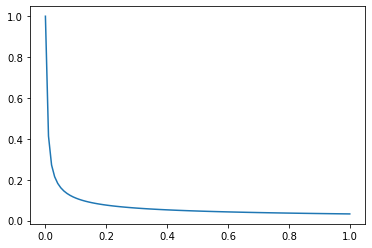

In [54]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1e-10,1,100)
y = np.array([P(elem) for elem in x])

plt.plot(x,y)
plt.show()

<h4> Zadanie4: 


- Wyznacz prawdopodobieństwo pozostawienia słowa występującego w korpusie z częstością 4% oraz 100% (cały korpus to tylko to słowo), czyli  P(0.04), P(1). Skomentuj otrzymane wyniki

- Dla jakiej wartości częstości prawdopodobieństwo pozostawienia wynosi w przybliżenu 0.5 i 1?

<h3> Metody redukcji wymiarowości


In [55]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50) #embeddingi 50D

In [56]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

<h4> SVD

In [57]:
A = np.array([[8,2,-1],[3,4,0],[4,1,3]])
print(A)

[[ 8  2 -1]
 [ 3  4  0]
 [ 4  1  3]]


In [58]:
U, S, Vt = np.linalg.svd(A) #rozklad macierzy A,  A = USVt

In [59]:
np.dot(np.dot(U,np.diag(S)),Vt) #sprawdzenie 

array([[ 8.00000000e+00,  2.00000000e+00, -1.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00, -3.76696205e-17],
       [ 4.00000000e+00,  1.00000000e+00,  3.00000000e+00]])

In [60]:
svd = TruncatedSVD(n_components=2, random_state=42) #truncated SVD
svd.fit(A) 

TruncatedSVD(random_state=42)

In [61]:
Vt = svd.components_
Vt

array([[ 0.92874673,  0.36804127,  0.04444244],
       [ 0.07398789, -0.30149516,  0.95059269]])

In [62]:
svd.explained_variance_ratio_

array([0.36801455, 0.35575045])

In [63]:
svd.explained_variance_ratio_.sum()

0.7237649989267075

In [64]:
svd.singular_values_

array([10.09318001,  3.16135545])

<h4> PCA

In [65]:
X = np.array([[1,-4,5],
              [3,6,1],
              [0,2,-13],
              [5,6,8],
              [-7,-2,1]])

X.shape

(5, 3)

In [66]:
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)
print(X_pca)

[[-4.12824364  4.70132591]
 [-1.55726889 -4.7610173 ]
 [13.0398852  -2.97440901]
 [-8.80575535 -4.5213729 ]
 [ 1.45138268  7.55547331]]


In [67]:
print(pca.explained_variance_ratio_)

[0.63241054 0.30814109]


<h4> t-SNE

In [68]:
X_tSNE = TSNE(n_components=2).fit_transform(X)
print(X_tSNE)

[[113.59251    -27.103952  ]
 [121.7994      69.201675  ]
 [134.00754     19.657959  ]
 [ 72.45755     50.437115  ]
 [ 68.14512     -0.25711372]]


<h4> MDS

In [69]:
X_MDS = MDS(n_components=2).fit_transform(X)
print(X_MDS)

[[ 5.53521359 -4.72656974]
 [-4.69629383 -1.86894848]
 [-4.38960198 12.70101156]
 [-4.06579229 -9.07048815]
 [ 7.61647451  2.96499481]]


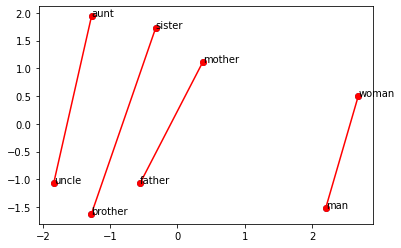

In [70]:
X = []
words = ['woman', 'man', 'sister','brother', 'uncle', 'aunt', 'mother', 'father'] #wybieram grupe slow
for word in words:
    X.append(glove[word].tolist()) #patrze jakie mają embeddingi
    
X = np.array(X) #tworze z nich macierz

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)  #redukuje liczbe zmiennych z 50 do 2 dla kazdego slowa


#Do rysowania: 

x = X_pca[:,0] #pierwsza zmienna
y = X_pca[:,1] #druga zmienna


plt.scatter(x,y)

for i, txt in enumerate(words):
    plt.annotate(txt, (x[i], y[i]))
    
for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    
plt.show()

<h4> Zadanie5:

Zaznacz na płaszczyźnie (i połącz linią) następujące nazwy państw/stolic: 'france', 'paris', 'poland', 'warsaw', 'germany', 'berlin', 'netherlands', 'amsterdam'. Do redukcji ilości zmiennych wykorzystaj PCA.

<h4> Zadanie6:

Zaznacz na płaszczyźnie (nie łącz) następujące słowa: 'dog', 'cat', 'cow', 'horse', 'sheep', 'sunflower', 'carrot', 'salad', 'potato','cucumber'. Do redukcji ilości zmiennych wykorzystaj MDS. Czy obserwujesz jakąś zależność?